In [1]:
import cltk
import medlatin
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
lat_cltk = cltk.NLP(language='lat', suppress_banner=True)
lat_cltk.pipeline.processes.remove(cltk.lexicon.processes.LatinLexiconProcess)
# remove process since it slows the code (it adds definitions to each word)
# lat_cltk.pipeline.processes.remove(cltk.embeddings.processes.LatinEmbeddingsProcess)
# remove process since it slows the code (it generates word2vec embeddings)

In [3]:
medlatin1_path = '../MedLatin/Corpora/MedLatinEpi'

medlatin1_texts, medlatin1_authors, medlatin_titles = medlatin.load_medlatin(medlatin1_path)

In [ ]:
medlatin1_pos, medlatin1_emb, medlatin1_tokens = medlatin.generate_text_vectors(
                                                        medlatin1_texts, lat_cltk
                                                        )

In [5]:
medlatin1_tokens_counter = medlatin.token_counter(medlatin1_tokens)

In [6]:
# we don't want to count punctuation among the most common tokens
stop_list = [',', '.', '', ';', ':']
medlatin1_most_common_tokens = medlatin.get_common_tokens(medlatin1_tokens_counter, 
                                                          n=20, stop_list=stop_list)

In [8]:
medlatin1_combined_pos_tokens = medlatin.combine_pos_most_common_tokens(medlatin1_tokens,
                                                                        medlatin1_pos,
                                                                        medlatin1_most_common_tokens)

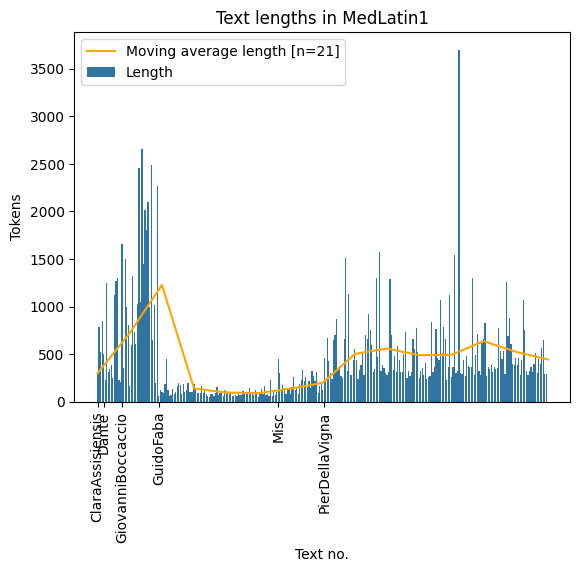

In [12]:
author_changes_idx = [i for i in range(len(medlatin1_authors)) if medlatin1_authors[i-1] != medlatin1_authors[i]]
author_changes_names = [medlatin1_authors[i] for i in author_changes_idx]
medlatin1_lens = [len(text) for text in medlatin1_pos]
medlatin1_lens_av = [medlatin1_lens[0]]
previous_i = 0
window_size = 21
for i in np.arange(window_size, len(medlatin1_lens)+1, window_size):
    window = medlatin1_lens[previous_i:i]
    medlatin1_lens_av.append(np.mean(window))
    previous_i = i

fig, ax = plt.subplots()

sns.barplot(medlatin1_lens, ax=ax, label='Length')
sns.lineplot(y=medlatin1_lens_av, x=np.arange(0, len(medlatin1_lens)+1, window_size), ax=ax, color='orange', label=f'Moving average length [n={window_size}]')
ax.set_title('Text lengths in MedLatin1')
ax.set_ylabel('Tokens')
ax.set_xlabel('Text no.')
ax.set_xticks(author_changes_idx)
ax.set_xticklabels(author_changes_names, rotation=90)
ax.legend();

In [13]:
medlatin1_combined_joined = [' '.join(combined_list) for combined_list in medlatin1_combined_pos_tokens]
medlatin1_tokens_joined = [' '.join(token_list) for token_list in medlatin1_tokens]
tfidf_bigrams_word = TfidfVectorizer(ngram_range=(2,2), max_features=100, analyzer='word')
tfidf_bigrams_char = TfidfVectorizer(ngram_range=(2,2), analyzer='char')
medlatin1_pos_tokens_tfidf = tfidf_bigrams_word.fit_transform(medlatin1_combined_joined)
medlatin1_char_tfidf = tfidf_bigrams_char.fit_transform(medlatin1_tokens_joined)
medlatin1_pos_token_char_tfidf = np.append(medlatin1_pos_tokens_tfidf.toarray(), 
                                           medlatin1_char_tfidf.toarray(), axis=1)
# we have to take the mean of each texts word embeddings to get one embedding per text
medlatin1_emb_mean = [np.array(embeddings).mean(axis=0) for embeddings in medlatin1_emb]
medlatin1_emb_mean = np.array(medlatin1_emb_mean)

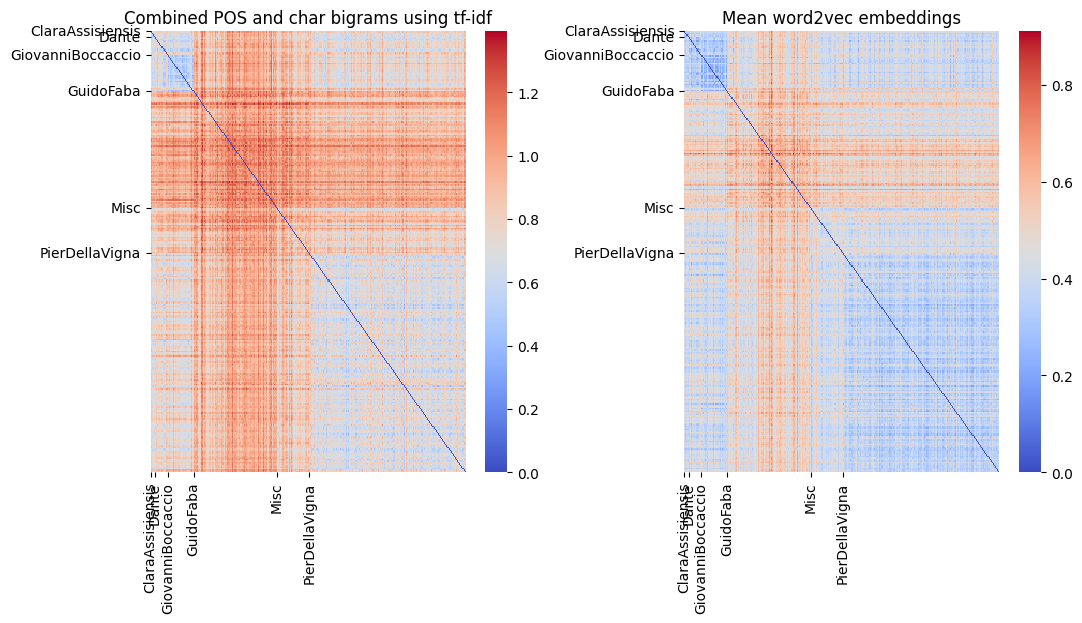

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

sns.heatmap(pairwise_distances(medlatin1_pos_token_char_tfidf), cmap='coolwarm', ax=axes[0])
axes[0].set_title('Combined POS and char bigrams using tf-idf')
axes[0].set_yticks(author_changes_idx)
axes[0].set_yticklabels(author_changes_names)
axes[0].set_xticks(author_changes_idx)
axes[0].set_xticklabels(author_changes_names)

sns.heatmap(pairwise_distances(medlatin1_emb_mean), cmap='coolwarm', ax=axes[1])
axes[1].set_title('Mean word2vec embeddings')
axes[1].set_yticks(author_changes_idx)
axes[1].set_yticklabels(author_changes_names)
axes[1].set_xticks(author_changes_idx)
axes[1].set_xticklabels(author_changes_names);

In [17]:
# there are six different authors in MedLatin1 (if we count misc as just one author)
kmean_100_tfidf = []
kmean_100_emb = []
for i in range(100):
    kmeans_tfidf = KMeans(n_clusters=6, n_init='auto').fit(medlatin1_pos_token_char_tfidf)
    kmeans_emb = KMeans(n_clusters=6, n_init='auto').fit(medlatin1_emb_mean)
    kmean_100_tfidf.append(kmeans_tfidf.labels_)
    kmean_100_emb.append(kmeans_emb.labels_)

kmean_100_tfidf = np.array(kmean_100_tfidf)
kmean_100_emb = np.array(kmean_100_emb)

In [18]:
concordances_heatmap_tfidf = []
concordances_heatmap_emb = []
for epi_idx in range(kmean_100_tfidf.shape[1]):
    concordances_tfidf = []
    concordances_emb = []

    for epi_jdx in range(kmean_100_tfidf.shape[1]):
        # to calculate the concordance rate we take all cluster labels for the text at epi_idx and compare to the labels
        # for the text at epi_jdx - if the first is [1, 1, 2] and the second is [1, 0, 2], then the concordance is [1, 0, 1]
        # the ones represent that they have the same cluster at that position, while 0 means different cluster labels
        # finally the concordance rate is 0.67, which we calculate by taking the mean of the concordance
        concordance_tfidf = sum(kmean_100_tfidf[:, epi_idx] == kmean_100_tfidf[:, epi_jdx])/kmean_100_tfidf.shape[0]
        concordances_tfidf.append(concordance_tfidf)
        concordance_emb = sum(kmean_100_emb[:, epi_idx] == kmean_100_emb[:, epi_jdx])/kmean_100_emb.shape[0]
        concordances_emb.append(concordance_emb)

    concordances_heatmap_tfidf.append(concordances_tfidf)
    concordances_heatmap_emb.append(concordances_emb)

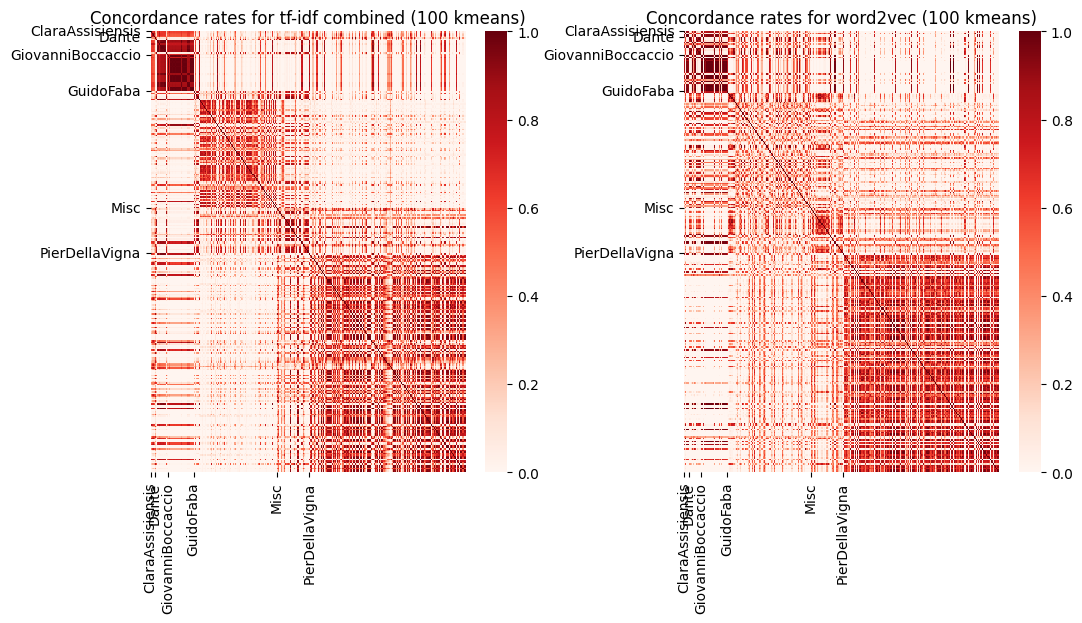

In [19]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

sns.heatmap(concordances_heatmap_tfidf, cmap='Reds', ax=axes[0])
axes[0].set_title('Concordance rates for tf-idf combined (100 kmeans)')
axes[0].set_yticks(author_changes_idx)
axes[0].set_yticklabels(author_changes_names)
axes[0].set_xticks(author_changes_idx)
axes[0].set_xticklabels(author_changes_names)

sns.heatmap(concordances_heatmap_emb, cmap='Reds', ax=axes[1])
axes[1].set_title('Concordance rates for word2vec (100 kmeans)')
axes[1].set_yticks(author_changes_idx)
axes[1].set_yticklabels(author_changes_names)
axes[1].set_xticks(author_changes_idx)
axes[1].set_xticklabels(author_changes_names);

### Throwing out authors with too few texts and adding most frequent words to pos tags

In [16]:
# Clara, and Misc have too few texts and they mess with the clustering
# let's try running the experiments without their texts to see the results
from_dante_idx = author_changes_idx[author_changes_names.index('Dante')]
to_misc_idx = author_changes_idx[author_changes_names.index('Misc')]
from_vigna_idx = author_changes_idx[author_changes_names.index('PierDellaVigna')]

In [18]:
# this results in 260 texts
medlatin1_texts_reduced = medlatin1_texts[from_dante_idx:to_misc_idx] + medlatin1_texts[from_vigna_idx:]

In [37]:
author_changes_reduced_idx = author_changes_idx[author_changes_names.index('Dante'):author_changes_names.index('Misc')+1]
author_changes_reduced_idx = [i - from_dante_idx for i in author_changes_reduced_idx]
author_changes_names_reduced = ['Dante', 'GiovanniBoccaccio', 'GuidoFaba', 'PierDellaVigna']

In [ ]:
medlatin1_reduced_pos = []
medlatin1_reduced_emb = []

for epistle in tqdm(medlatin1_texts_reduced):
    epistle_doc = lat_cltk.analyze(epistle)
    medlatin1_reduced_pos.append(epistle_doc.pos)
    # word2vec embeddings, meaning we get one embedding per token per epistle
    medlatin1_reduced_emb.append(epistle_doc.embeddings)

In [41]:
medlatin1_reduced_pos_joined = [' '.join(pos_list) for pos_list in medlatin1_reduced_pos]
tfidf_bigrams_word = TfidfVectorizer(ngram_range=(2,2), max_features=100, analyzer='word')
tfidf_bigrams_char = TfidfVectorizer(ngram_range=(2,2), analyzer='char')
medlatin1_pos_reduced_tfidf_word = tfidf_bigrams_word.fit_transform(medlatin1_reduced_pos_joined)
medlatin1_pos_reduced_tfidf_char = tfidf_bigrams_char.fit_transform(medlatin1_reduced_pos_joined)
medlatin1_pos_reduced_tfidf_combined = np.append(medlatin1_pos_reduced_tfidf_char.toarray(), medlatin1_pos_reduced_tfidf_word.toarray(), axis=1)
# we have to take the mean of each texts word embeddings to get one embedding per text
medlatin1_reduced_emb_mean = [np.array(embeddings).mean(axis=0) for embeddings in medlatin1_reduced_emb]
medlatin1_reduced_emb_mean = np.array(medlatin1_reduced_emb_mean)

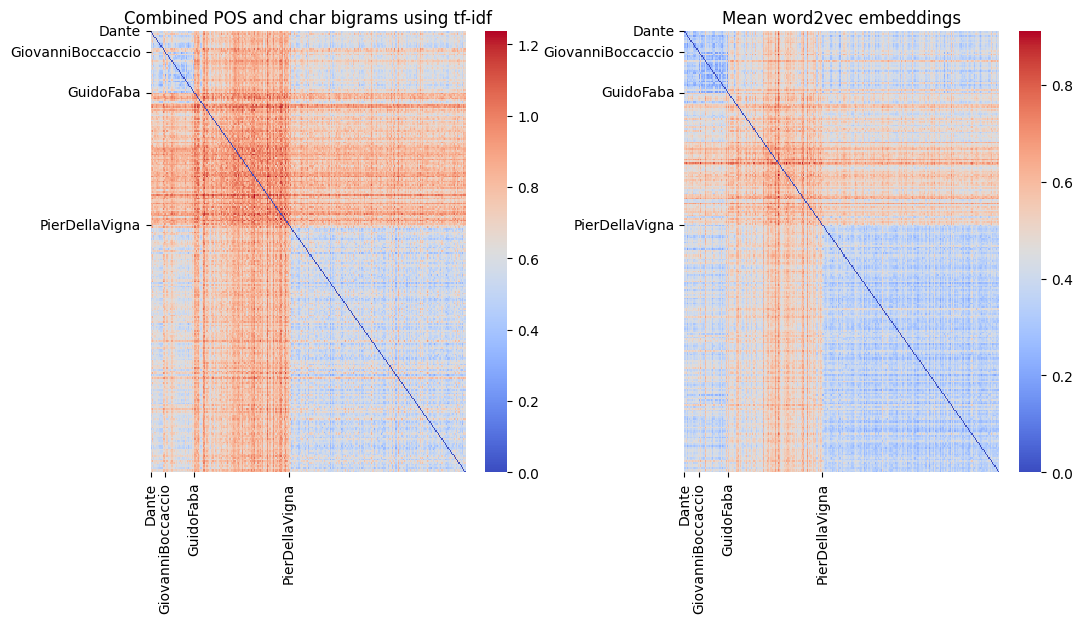

In [42]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

sns.heatmap(pairwise_distances(medlatin1_pos_reduced_tfidf_combined), cmap='coolwarm', ax=axes[0])
axes[0].set_title('Combined POS and char bigrams using tf-idf')
axes[0].set_yticks(author_changes_reduced_idx)
axes[0].set_yticklabels(author_changes_names_reduced)
axes[0].set_xticks(author_changes_reduced_idx)
axes[0].set_xticklabels(author_changes_names_reduced)

sns.heatmap(pairwise_distances(medlatin1_reduced_emb_mean), cmap='coolwarm', ax=axes[1])
axes[1].set_title('Mean word2vec embeddings')
axes[1].set_yticks(author_changes_reduced_idx)
axes[1].set_yticklabels(author_changes_names_reduced)
axes[1].set_xticks(author_changes_reduced_idx)
axes[1].set_xticklabels(author_changes_names_reduced);

In [43]:
# there are four different authors in the reduced set of texts
n_authors = len(author_changes_names_reduced)
kmean_100_tfidf_reduced = []
kmean_100_emb_reduced = []
for i in range(100):
    kmeans_tfidf_reduced = KMeans(n_clusters=n_authors, n_init='auto').fit(medlatin1_pos_reduced_tfidf_combined)
    kmeans_emb_reduced = KMeans(n_clusters=n_authors, n_init='auto').fit(medlatin1_reduced_emb_mean)
    kmean_100_tfidf_reduced.append(kmeans_tfidf_reduced.labels_)
    kmean_100_emb_reduced.append(kmeans_emb_reduced.labels_)

kmean_100_tfidf_reduced = np.array(kmean_100_tfidf_reduced)
kmean_100_emb_reduced = np.array(kmean_100_emb_reduced)

In [44]:
concordances_heatmap_tfidf_reduced = []
concordances_heatmap_emb_reduced = []
for epi_idx in range(kmean_100_tfidf_reduced.shape[1]):
    concordances_tfidf_reduced = []
    concordances_emb_reduced = []

    for epi_jdx in range(kmean_100_tfidf_reduced.shape[1]):
        # to calculate the concordance rate we take all cluster labels for the text at epi_idx and compare to the labels
        # for the text at epi_jdx - if the first is [1, 1, 2] and the second is [1, 0, 2], then the concordance is [1, 0, 1]
        # the ones represent that they have the same cluster at that position, while 0 means different cluster labels
        # finally the concordance rate is 0.67, which we calculate by taking the mean of the concordance
        concordance_tfidf_reduced = sum(kmean_100_tfidf_reduced[:, epi_idx] == kmean_100_tfidf_reduced[:, epi_jdx])/kmean_100_tfidf_reduced.shape[0]
        concordances_tfidf_reduced.append(concordance_tfidf_reduced)
        concordance_emb_reduced = sum(kmean_100_emb_reduced[:, epi_idx] == kmean_100_emb_reduced[:, epi_jdx])/kmean_100_emb_reduced.shape[0]
        concordances_emb_reduced.append(concordance_emb_reduced)

    concordances_heatmap_tfidf_reduced.append(concordances_tfidf_reduced)
    concordances_heatmap_emb_reduced.append(concordances_emb_reduced)

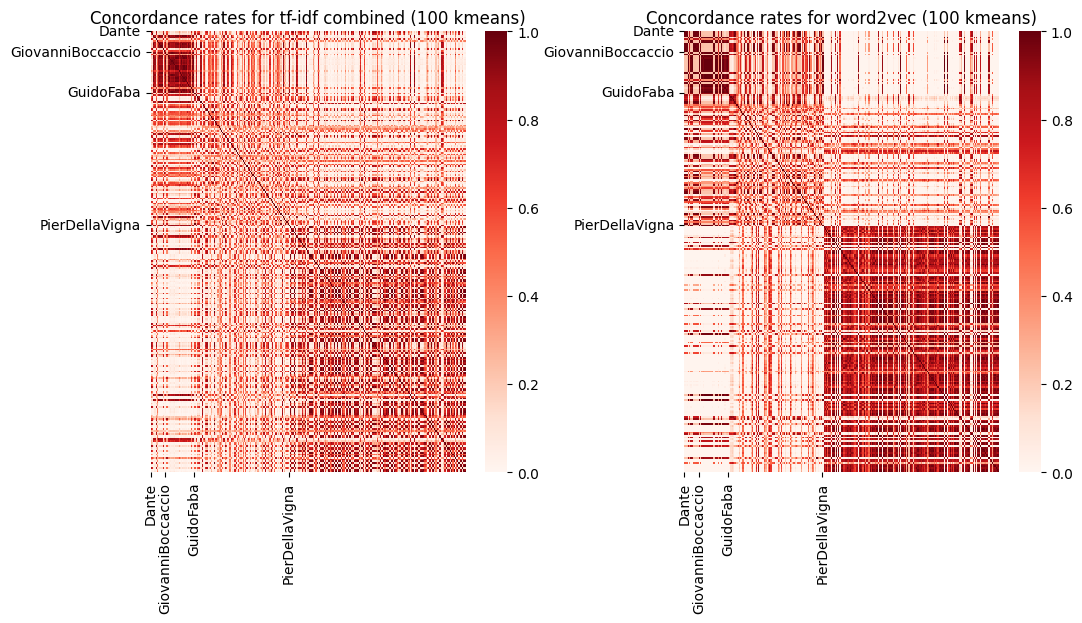

In [45]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

sns.heatmap(concordances_heatmap_tfidf_reduced, cmap='Reds', ax=axes[0])
axes[0].set_title('Concordance rates for tf-idf combined (100 kmeans)')
axes[0].set_yticks(author_changes_reduced_idx)
axes[0].set_yticklabels(author_changes_names_reduced)
axes[0].set_xticks(author_changes_reduced_idx)
axes[0].set_xticklabels(author_changes_names_reduced)

sns.heatmap(concordances_heatmap_emb_reduced, cmap='Reds', ax=axes[1])
axes[1].set_title('Concordance rates for word2vec (100 kmeans)')
axes[1].set_yticks(author_changes_reduced_idx)
axes[1].set_yticklabels(author_changes_names_reduced)
axes[1].set_xticks(author_changes_reduced_idx)
axes[1].set_xticklabels(author_changes_names_reduced);